In [629]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import matplotlib.cm as cm
import scipy.misc
from astropy.io import fits
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize,SquaredStretch
from astropy.cosmology import WMAP9 as cosmo
from scipy.optimize import curve_fit
from scipy import integrate

In [630]:
get_ipython().magic('matplotlib inline')
pd.set_option('display.max_columns', None)
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.dpi'] = 75

In [631]:
#### calculate Lya Flux

def Fline(Bw, NB, Clambda_Bw=4035, Dlambda_Bw=1278, Clambda_NB=4030, Dlambda_NB=45, z=2.3):
    c=3e18# unit:(Angstrom/s)
    f_Bw = 10**(-0.4*(Bw+48.6))
    f_NB = 10**(-0.4*(NB+48.6))# f_v (erg s-1 cm-2 HZ-1)
    f_Bw = c / (Clambda_Bw ** 2) * f_Bw
    f_NB = c / (Clambda_NB ** 2) * f_NB# f_lambda (erg s-1 cm-2 A-1)
    f_cont = (f_Bw * Dlambda_Bw - f_NB * Dlambda_NB) / (Dlambda_Bw - Dlambda_NB)
    f_line = (f_NB - f_cont) * Dlambda_NB * (u.erg / (u.cm ** 2 * u.s))# fluxunit
    return f_line

In [632]:
#### calculate Lya Luminosity

def Luminosity(Bw, NB, Clambda_Bw=4035, Dlambda_Bw=1278, Clambda_NB=4030, Dlambda_NB=45):
    z = (Clambda_NB - 1215.7)/1215.7
    f_line = Fline(Bw, NB, Clambda_Bw, Dlambda_Bw, Clambda_NB, Dlambda_NB, z)
    L_line = (4* np.pi * cosmo.comoving_distance(z)**2 * f_line).to(u.erg/u.s)
    return L_line

In [633]:
def Scaleimgconverter(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=SquaredStretch())
    return norm

In [634]:
def CountPixel(img, x, y, boundary, lenth=30, greater='True'):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    if greater == 'True':
        return len(np.where(img > boundary)[0])
    else:
        return len(np.where(img < boundary)[0])

def CountPixel1(img,boundary,greater='True'):
    #img = img[ymin : ymax, xmin : xmax]
    if greater == 'True':
        return len(np.where(img > boundary)[0])
    else:
        return len(np.where(img < boundary)[0])

In [635]:
def FitsPresent(img, x, y, len=60):#, n):
    norm = Scaleimgconverter(img)
    plt.imshow(img, origin = 'lower', norm = norm, cmap=plt.cm.gray)
    # fig.colorbar(im)
    # plt.scatter(x, y, color='', marker='o', edgecolors='r', s=200)
    plt.xlim(x - len/2, x + len/2)
    plt.ylim(y - len/2, y + len/2)
    # plt.savefig('D:/lyadata/figure/4/' + n + '.png')

In [636]:
catfile_Bw = 'Bw.cat'#sigma = 1.2
catfile_NB = 'test_1412NB.cat'#sigma = 1.2
catfile_NBBw = 'NB-Bw.cat'# dualmode, detect NB, measure Bw, sigma = 5
catfile_NBNB = 'NB-NB.cat'# dualmode, detect NB, measure NB, sigma = 5
file_SDSS = 'J1412_1503_SDSS'
fitsfile_Bw = 'J1412_1503_Bw.fits'
fitsfile_NB = 'J1412_1503_NB.fits'

In [637]:
#### load data to pd.DateFrame


names11 = ['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_J2000', 'DELTA_J2000', 'FLUX_APER', 'FLUXERR_APER', \
          'MAG_APER', 'MAGERR_APER']
names12 = ['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_J2000', 'DELTA_J2000', 'FLUX_APER', 'FLUXERR_APER', \
          'MAG_APER', 'MAGERR_APER', 'FLAGS', 'NITER_MODEL', 'ISOAREA_IMAGE', 'ISOAREAF_IMAGE']
Bw_rawdata = pd.DataFrame(np.genfromtxt(catfile_Bw, delimiter = None, names = names11))
NB_rawdata = pd.DataFrame(np.genfromtxt(catfile_NB, delimiter = None, names = names12))

NBBw_data = pd.DataFrame(np.genfromtxt(catfile_NBBw, delimiter = None, names = names12))
NBNB_data = pd.DataFrame(np.genfromtxt(catfile_NBNB, delimiter = None, names = names12))

names2 = ['_RAJ2000', '_DEJ2000', 'RA_ICRS', 'DE_ICRS', 'mode', 'q_mode', 'class','SDSS12', 'm_SDSS12', 'ObsDate', 'Q', 'umag',\
          'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'zsp', 'zph', 'e_zph', '<zph>']
SDSS_rawdata = pd.DataFrame(np.genfromtxt(file_SDSS, delimiter = '\t', skip_header = 10,names = names2))

# color transfer from u&r to b band
SDSS_rawdata['bmag'] = SDSS_rawdata.umag - 0.8116 * (SDSS_rawdata.umag - SDSS_rawdata.gmag) + 0.1313
# SDSS_rawdata['bmag'] = SDSS_rawdata.gmag + 0.3130 * (SDSS_rawdata.gmag - SDSS_rawdata.rmag) + 0.2271

In [638]:
#### data screening

# pick points whose flux > 0
Bw_data = Bw_rawdata[Bw_rawdata.FLUX_APER > 0].reset_index(drop = 'True')
NB_data = NB_rawdata[NB_rawdata.FLUX_APER > 0].reset_index(drop = 'True')

Bw_data['mag'] = -2.5 * np.log10(Bw_data.FLUX_APER)
NB_data['mag'] = -2.5 * np.log10(NB_data.FLUX_APER)

# pick points whose class are star(class = 6)
SDSS_data = SDSS_rawdata[(SDSS_rawdata['class'] == 6) & (SDSS_rawdata.bmag > 17.5) & (SDSS_rawdata.bmag < 20.5)].reset_index(drop = 'True')

# match source
将sigma=1.5的Bw/NB的catalog与SDSS的标准源相匹配

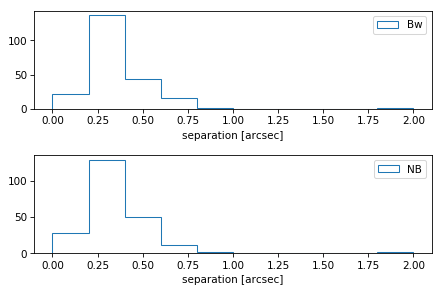

In [639]:
#### match source point between Bw/NB and SDSS

coo_Bw = SkyCoord(list(Bw_data.ALPHA_J2000) * u.degree, list(Bw_data.DELTA_J2000) * u.degree)
coo_NB = SkyCoord(list(NB_data.ALPHA_J2000) * u.degree, list(NB_data.DELTA_J2000) * u.degree)
coo_SDSS = SkyCoord(list(SDSS_data._RAJ2000) * u.degree, list(SDSS_data._DEJ2000) * u.degree)
idx_Bw, d2d_Bw, d3d_Bw = coo_SDSS.match_to_catalog_sky(coo_Bw)
idx_NB, d2d_NB, d3d_NB = coo_SDSS.match_to_catalog_sky(coo_NB)

# separation
plt.subplot(211)
plt.hist(d2d_Bw.arcsec, histtype='step', range=(0,2), label='Bw')
plt.xlabel('separation [arcsec]')
plt.tight_layout()
plt.legend()
plt.subplot(212)
plt.hist(d2d_NB.arcsec, histtype='step', range=(0,2), label='NB')
plt.xlabel('separation [arcsec]')
plt.tight_layout()
plt.legend()
plt.show()

In [640]:
##### select common points in Bw and NB

index_Bw = np.where((d2d_Bw < Angle('0d00m0.5s')))
index_NB = np.where((d2d_NB < Angle('0d00m0.5s')))
index = [index for index in index_Bw[0] if index in index_NB[0]]
idx_Bw = idx_Bw[index]
idx_NB = idx_NB[index]

# calibrate
匹配完成后利用SDSS的绝对星等对Bw/NB的星等进行定标,得到zeropoint

D:\software\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
D:\software\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


standard deviation of zero points is: 0.09719944969423462
Zero point for Bw band is:  25.62706896467671
standard deviation of zero points is: 0.23781248948577835
Zero point for NB band is:  22.680023664152557


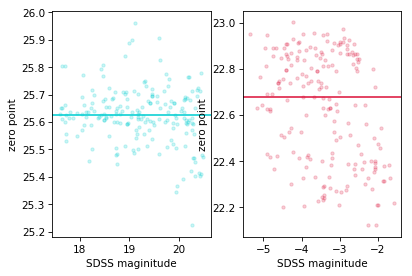

In [641]:
#### calibrate

Bw_mag = np.array([Bw_data['mag'][i] for i in idx_Bw])
NB_mag = np.array([NB_data['mag'][i] for i in idx_NB])
SDSS_mag = [SDSS_data.bmag[i] for i in index]
subt_SB = SDSS_mag - Bw_mag

zp_Bw = sigma_clip(subt_SB, sigma = 3, iters = 10)
zeropoint_Bw = np.median(zp_Bw)
subt_BN = Bw_mag + zeropoint_Bw - NB_mag
zp_NB = sigma_clip(subt_BN, sigma = 3, iters = 10)
zeropoint_NB = np.median(zp_NB)

plt.figure()
plt.subplot(121)
plt.scatter(SDSS_mag, subt_SB, s = np.pi * 1.75**2, c = '#00CED1', alpha=0.2)
plt.axhline(np.median(zp_Bw), c = '#00CED1')
plt.xlabel('SDSS maginitude'); plt.ylabel('zero point')
print('standard deviation of zero points is:', np.std(zp_Bw))
print("Zero point for Bw band is: ", zeropoint_Bw)
plt.subplot(122)
plt.scatter(NB_mag, subt_BN, s = np.pi * 1.75**2, c = '#DC143C', alpha=0.2)
plt.axhline(np.median(zp_NB), c = '#DC143C')
plt.xlabel('SDSS maginitude'); plt.ylabel('zero point')
print('standard deviation of zero points is:', np.std(zp_NB))
print("Zero point for NB band is: ", zeropoint_NB)
plt.show()

In [642]:
#### correct magnitude

Bw_data.mag = Bw_data.mag + zeropoint_Bw
NB_data.mag = NB_data.mag + zeropoint_NB

NBBw_data.MAG_APER = NBBw_data.MAG_APER + zeropoint_Bw
NBNB_data.MAG_APER = NBNB_data.MAG_APER + zeropoint_NB

# Select Blob
将sigma=1.5的Bw与NB的catalog中的源相匹配,初筛得到符合条件的LAE

(由于这样相匹配仍会存在匹配失误的可能,还需利用dual mode在detect NB source的基础上measure Bw source)

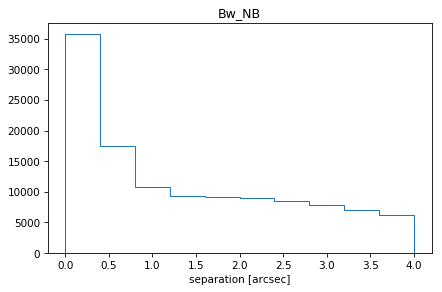

In [643]:
#### match Bw and NB

idx, d2d, d3d = coo_NB.match_to_catalog_sky(coo_Bw)
# seperation
plt.hist(d2d.arcsec, histtype='step', range=(0,4))
plt.xlabel('separation [arcsec]')
plt.title('Bw_NB')
plt.tight_layout()
plt.show()

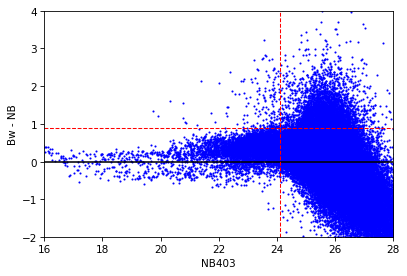

In [644]:
index_Bw_NB = np.where((d2d < Angle('0d00m02s')))
idx = idx[index_Bw_NB]
NB_data = NB_data.loc[index_Bw_NB].reset_index(drop = 'True')
Bw_data = Bw_data.loc[idx].reset_index(drop = 'True')

mag_thresh = 24.1
plt.scatter(NB_data.mag, Bw_data.mag - NB_data.mag, color = 'b', s = 1)
plt.axhline(0, color='k', linestyle='solid')
plt.axhline(0.9, color='r', linestyle='--', linewidth = 1)
plt.axvline(mag_thresh, color='r', linestyle='--', linewidth = 1)
plt.axis([16, 28, -2, 4])
plt.xlabel('NB403')
plt.ylabel('Bw - NB')
plt.show()

In [645]:
Bw_select = Bw_data.copy()
Bw_select['NB_mag'] = NB_data.mag
Bw_select['Bw_minus_NB'] = Bw_data.mag - NB_data.mag
Bw_select['NB_X'] = NB_data.X_IMAGE
Bw_select['NB_Y'] = NB_data.Y_IMAGE
Bw_select['NB_RA'] = NB_data.ALPHA_J2000
Bw_select['NB_DE'] = NB_data.DELTA_J2000
Bw_select['ISOAREAF'] = NB_data.ISOAREAF_IMAGE
Bw_select =  Bw_select[(Bw_select.Bw_minus_NB > 0.9) & (Bw_select.NB_mag < mag_thresh) & (Bw_select.NB_mag > 16)].reset_index(drop = 'True')

将dual mode提取的Bw与NB的源的catalog相匹配(sigma=5),保证Bw magnitude是在NB sourced的原位置测量得到

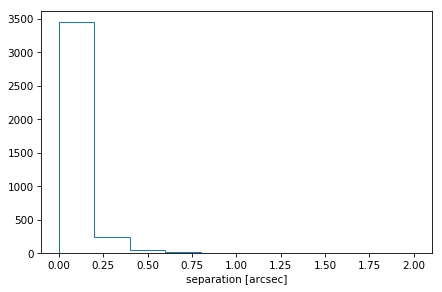

In [646]:
#### match Bw and NB in dual mode

coo_NBBw = SkyCoord(list(NBBw_data.ALPHA_J2000) * u.degree, list(NBBw_data.DELTA_J2000) * u.degree)
coo_NBNB = SkyCoord(list(NBNB_data.ALPHA_J2000) * u.degree, list(NBNB_data.DELTA_J2000) * u.degree)
idx, d2d, d3d = coo_NBNB.match_to_catalog_sky(coo_NBBw)

# separation
plt.subplot(111)
plt.hist(d2d.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.tight_layout()
plt.show()

In [647]:
index = np.where((d2d < Angle('0d00m0.5s')))
idx = idx[index]
NBNB_data = NBNB_data.loc[index].reset_index(drop = 'True')
NBBw_data = NBBw_data.loc[idx].reset_index(drop = 'True')

LAE = NBBw_data.copy()
LAE['NB_mag'] = NBNB_data.MAG_APER 
# LAE['Bw_minus_NB'] = NBBw_data.MAG_APER  - NBNB_data.MAG_APER 
LAE['NB_X'] = NBNB_data.X_IMAGE
LAE['NB_Y'] = NBNB_data.Y_IMAGE
LAE['NB_RA'] = NBNB_data.ALPHA_J2000
LAE['NB_DE'] = NBNB_data.DELTA_J2000
LAE['NB_ISOAREAF'] = NBNB_data.ISOAREAF_IMAGE

将dual mode的source匹配到初筛LAE上,得到精确筛选的LAE

In [648]:
coo_Bwselect = SkyCoord(list(Bw_select.NB_RA) * u.degree, list(Bw_select.NB_DE) * u.degree)
coo_LAE = SkyCoord(list(LAE.NB_RA) * u.degree, list(LAE.NB_DE) * u.degree)
idx, d2d, d3d = coo_Bwselect.match_to_catalog_sky(coo_LAE)

# plt.subplot(111)
# plt.hist(d2d.arcsec, histtype='step', range=(0,2))
# plt.xlabel('separation [arcsec]')
# plt.tight_layout()
# plt.show()

LAE = LAE.loc[idx].reset_index(drop = 'True')

计算luminosity, surface brightness

In [649]:
hdu1 = fits.open(fitsfile_Bw)[0]
wcs1 = WCS(hdu1.header)  # ; hdu1.close()
hdu2 = fits.open(fitsfile_NB)[0]
wcs2 = WCS(hdu2.header)  # ; hdu2.close()

img = hdu2.data - 10**((zeropoint_NB - zeropoint_Bw)/2.5) * hdu1.data

# # get area of area per pixel
# ra, dec = wcs1.all_pix2world([0, wcs1.array_shape[0]], [0, wcs1.array_shape[1]], 1)
# deg_to_pix = (dec[1] - dec [0]) * (ra[0] - ra[1])/wcs1.array_shape[0]/wcs1.array_shape[1] * 3600**2# unit:arcsec^2/pixel^2
# print(deg_to_pix)

# # calculate candidate size
# arcsecarea = np.array([CountPixel(img, Bw_select['NB_X'][i], Bw_select['NB_Y'][i], 0.010, 30) * deg_to_pix for i in range(len(Bw_select['NB_Y']))])
# arcsecarea1 = np.array([CountPixel(img, Bw_select['NB_X'][i], Bw_select['NB_Y'][i], -0.10, 30, greater='False') * deg_to_pix for i in range(len(Bw_select['NB_Y']))])
# Bw_select['arcsecarea'] = arcsecarea
# Bw_select['lyaLuminosity'] = Luminosity(np.array(Bw_select.mag), np.array(Bw_select.NB_mag))
# Bw_select['surfacebrightness'] = Fline(np.array(Bw_select.mag), np.array(Bw_select.NB_mag))/Bw_select.arcsecarea
# print(len(Bw_select['lyaLuminosity']))

ra, dec = wcs1.all_pix2world([0, wcs1.array_shape[0]], [0, wcs1.array_shape[1]], 1)
deg_to_pix = (dec[1] - dec[0]) * (ra[0] - ra[1])/wcs1.array_shape[0] / wcs1.array_shape[1] * 3600**2  # unit:arcsec^2/pixel^2
LAE['NB_ISOAREAF'] = LAE.NB_ISOAREAF * deg_to_pix; LAE.ISOAREAF_IMAGE = LAE.ISOAREAF_IMAGE * deg_to_pix
LAE['lyaLuminosity'] = np.abs(Luminosity(np.array(LAE.MAG_APER), np.array(LAE.NB_mag)))
LAE['surfacebrightness'] = np.abs(Fline(np.array(LAE.MAG_APER), np.array(LAE.NB_mag))/LAE.NB_ISOAREAF)
print(len(LAE['lyaLuminosity']))
print((dec[1] - dec[0]) * (ra[0] - ra[1])*3600)

172
1845.2617140210766


进一步筛选得到blob

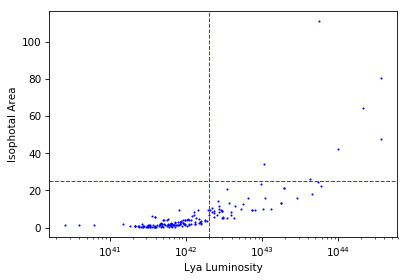

In [650]:
plt.semilogx()
plt.scatter(LAE.lyaLuminosity,LAE.NB_ISOAREAF, color = 'b', s=1)
plt.axhline(25, color='r', linestyle='--', linewidth = 1)
plt.axvline(2e42, color='r', linestyle='--', linewidth = 1)
plt.xlabel('Lya Luminosity')
plt.ylabel('Isophotal Area')
plt.show()

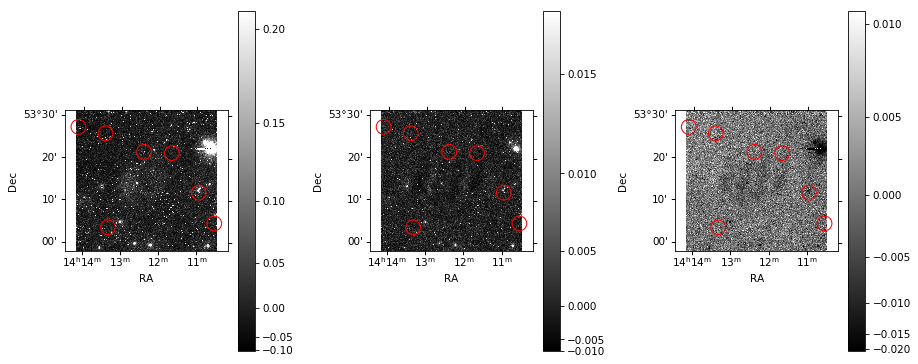

In [660]:
# the true lya blob candidate
LAE = LAE[(LAE.lyaLuminosity > 2e41)].reset_index(drop = 'True')
LAE.to_csv('LAE.csv')
blob = LAE[(LAE.lyaLuminosity > 2e42) & (LAE.NB_ISOAREAF > 25)]

fig = plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.5)#left=None, bottom=None, right=None, top=None
ax1 = fig.add_subplot(131, projection=wcs1)
norm1 = Scaleimgconverter(hdu1.data)
plt.imshow(hdu1.data, origin='lower', norm = norm1, cmap=plt.cm.gray)
plt.colorbar()
plt.scatter(blob.NB_X, blob.NB_Y, transform=ax1.get_transform(wcs1), color='', marker='o', edgecolors='r', s=200)
plt.xlabel('RA'); plt.ylabel('Dec')
ax2 = fig.add_subplot(132, projection=wcs2)
norm2 = Scaleimgconverter(hdu2.data)
plt.imshow(hdu2.data, origin='lower', norm = norm2, cmap=plt.cm.gray)
plt.colorbar()
plt.scatter(blob.NB_X, blob.NB_Y, transform=ax2.get_transform(wcs2), color='', marker='o', edgecolors='r', s=200)
plt.xlabel('RA'); plt.ylabel('Dec')
ax3 = fig.add_subplot(133, projection=wcs2)
norm = Scaleimgconverter(img)
plt.imshow(img, origin='lower', norm = norm, cmap=plt.cm.gray)
plt.colorbar()
plt.scatter(blob.NB_X, blob.NB_Y, transform=ax3.get_transform(wcs2), color='', marker='o', edgecolors='r', s=200)
plt.xlabel('RA'); plt.ylabel('Dec')
plt.show()

# Luminosity Function

In [652]:
#### calculate volume(Mpc3)

z = ((4030-1215.7)/1215.7)
vel = cosmo.comoving_distance(z+45/2/1215.7)-cosmo.comoving_distance(z-45/2/1215.7)
print(vel)
count = CountPixel1(img, 0.005, greater='False')
print(count,wcs1.array_shape[0]*wcs1.array_shape[1], count/wcs1.array_shape[0]/wcs1.array_shape[1])
volume = (count/wcs1.array_shape[0]/wcs1.array_shape[1])*np.abs((ra[1]-ra[0])*(dec[1]-dec[0]))* (2*np.pi/360)**2 * cosmo.comoving_distance(z)**2 * vel
print(volume)

# fig = plt.figure()
# img1 = img.copy()
# img1 = np.where(img1>0.01,'NAN',img1)
# ax = fig.add_subplot(111, projection=wcs2)
# norm = Scaleimgconverter(img1)
# plt.imshow(img1, origin='lower', norm = norm, cmap=plt.cm.summer_r)
# plt.colorbar()
# plt.xlabel('RA'); plt.ylabel('Dec')
# plt.show()

47.91952902709454 Mpc
58958770 63615951 0.9267922442910584
227572.46650278542 Mpc3


phi*= 5.541635597945012e-07
L*= 3.1622776601683794e+43
alpha= -1.5999988420370612
123.07032133972962
-6.2563620355737894 43.5 -1.5999988420370612 -3.266966382004868


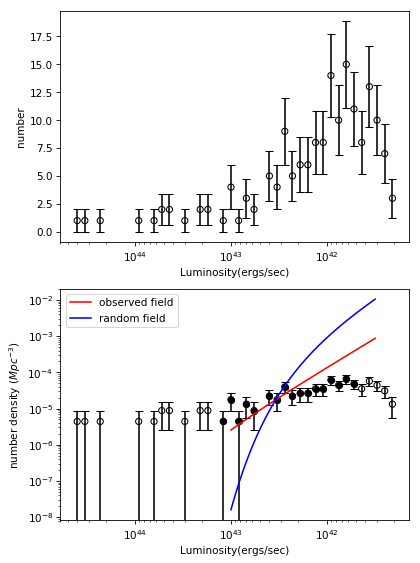

In [653]:
###### Schecher Luminosity Function

binwidth = 0.08
mag = np.log10(LAE['lyaLuminosity'])
x = np.power(10, np.arange(binwidth*(min(mag)//binwidth + 1/2), binwidth*(max(mag)//binwidth + 3), binwidth))
y1 = np.histogram(mag, bins=np.arange(binwidth*(min(mag)//binwidth), binwidth*(max(mag)//binwidth + 3), binwidth))[0]
y2 = y1/volume.value

# print(x, len(x))
# print(y1, len(y1))

X1 = np.delete(np.vstack([x, y1]), np.where(y1==0) ,axis=1)
X2 = np.delete(np.vstack([x, y2]), np.where(y2==0) ,axis=1)
X2_fit = np.delete(X2, [0, 1, 2, 3, 4, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], axis=1)

error1 = np.sqrt(X1[1])
error2 = np.sqrt(X1[1])/volume.value

def LuminoFunc(x, a, b, c):
    return (a)*np.power(x/b,c) *np.exp(-x/b)

def LuminoFunc1(x, a, b, c):
    return (a)*np.power(x,c) *np.exp(-x)


param_bounds =([10**-7., 10**40., -2], [1, 10**44., -1.0])
popt, pcov = curve_fit(LuminoFunc, X2_fit[0], X2_fit[1], p0=[10**(-6), 10**43.5, -1.6], bounds=param_bounds, maxfev=50000)
a = popt[0]; b = popt[1]; c = popt[2]; print('phi*=', a); print('L*=', b); print('alpha=', c)
xvals = np.linspace(10**41.5, 10**43,200)
yvals = LuminoFunc(xvals, a, b, c)

a0, b0, c0 = 10**(-2.86), 10**42.1, -1.65 #constant at z=2.3
v, err = integrate.quad(LuminoFunc1, 0.65, 1000, args=(a0, b0, c0)) # N_field
# print('err=',err)
# v = v * 15**3; print('random field Lya number density:', v, '/Mpc3')

fig = plt.figure(figsize=(6,9))
ax1 = fig.add_subplot(211)
ax1.set_xscale("log")
plt.scatter(X1[0], X1[1],color = '', edgecolors='black', marker='o', s=35)
plt.errorbar(X1[0], X1[1], fmt='None', yerr=error1, ecolor='black', capsize=4)
plt.xlabel('Luminosity(ergs/sec)')
plt.ylabel('number')
ax1.invert_xaxis()

ax2 = fig.add_subplot(212)
ax2.set_xscale("log")
ax2.set_yscale("log")
plt.scatter(X2[0], X2[1], color = '', edgecolors='black', marker='o', s=35)
plt.scatter(X2_fit[0], X2_fit[1], color = 'black', edgecolors='black', marker='o', s=35)
plt.errorbar(X2[0], X2[1], fmt='None', yerr=error2, ecolor='black', capsize=4)
plt.plot(xvals, yvals, color='r', label='observed field')
plt.plot(xvals, LuminoFunc(xvals, a0, b0, c0), color='b', label='random field')
# plt.axhline(v, color='r', linestyle='--', linewidth = 1)
# plt.text(10**41.8, 10**-3.0, 'random field number density')
plt.xlabel('Luminosity(ergs/sec)')
plt.ylabel('number density ($Mpc^{-3}$)')
plt.legend()
ax2.invert_xaxis()

print(v*volume.value)
print(np.log10(a), np.log10(b), c, np.log10(v))

# Density Map

sigma is 3.1700000000000004


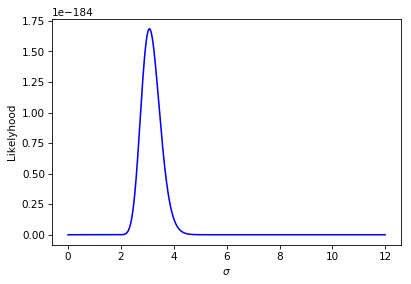

In [654]:
#### kernal density estimation

def Gaussian2D(r, sigma):
    return 1/(2*np.pi*sigma**2)*np.exp(-r**2/2/sigma**2)

def f_i(i, x, sigma):
    x1 = np.delete(x, i, axis=1)
    r = np.sqrt((x[0][i]-x1[0])**2 + (x[1][i]-x1[1])**2)
    Sum = np.sum(Gaussian2D(r, sigma))
    return Sum

def Likelyhood(x, sigma):
    list = [f_i(i, x, sigma) for i in range(len(x[0]))]
    Prod = np.prod(list)
    return Prod

ra, dec = wcs1.all_pix2world(Bw_select.NB_X, Bw_select.NB_Y,1)
emitter=np.vstack([60*ra, 60*dec])

step = 0.01
sigma = np.arange(step, 12, step)
Lh = [Likelyhood(emitter, s) for s in sigma]
Sigma = Lh.index(max(Lh))*step+0.1
print('sigma is {}'.format(Sigma))
plt.plot(sigma,Lh, color='b')
plt.xlabel('$\sigma$')
plt.ylabel('Likelyhood')
plt.show()

D:\software\Anaconda\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


<Figure size 600x600 with 0 Axes>

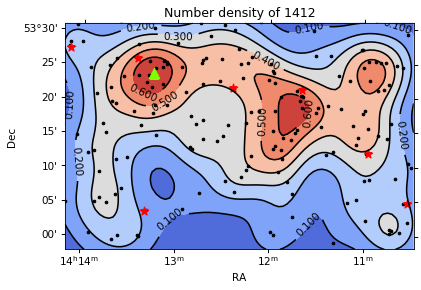

In [655]:
#### number density map

gridwidth = 100# sampling step
xx, yy = np.meshgrid(np.arange(0, wcs1.array_shape[0], gridwidth), np.arange(0, wcs1.array_shape[1], gridwidth))
ra_xx, dec_yy = wcs1.all_pix2world(xx+gridwidth/2, yy+gridwidth/2, 1); ra_xx, dec_yy = 60*ra_xx, 60*dec_yy
f = [Gaussian2D(np.sqrt((ra_xx - emitter[0, i])**2 + (dec_yy - emitter[1, i])**2), Sigma) for i in range(len(emitter[0]))]
# f = np.sum(f, axis=0)/deg_to_pix *3600/gridwidth**2
f = np.sum(f, axis=0)/abs(ra_xx[0, 1]-ra_xx[0, 0])/abs((dec_yy[1, 0]-dec_yy[0, 0])) # number density
center = (gridwidth*(np.where(f == np.max(f))[1][0] + 1/2), gridwidth*(np.where(f == np.max(f))[0][0] +1/2))

fig = plt.figure(figsize=(8, 8))
fig = plt.figure()
ax = fig.gca(projection=wcs1)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm', lw=1)
cset = ax.contour(xx, yy, f, colors='k', lw=1)
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.axis([xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]])
plt.scatter(Bw_select.NB_X, Bw_select.NB_Y, marker='.', color='black', s=25)
plt.scatter(blob.NB_X, blob.NB_Y, marker='*', color='r', s=75)
plt.scatter(center[0], center[1], marker='^', color='chartreuse', s=100)
plt.title('Number density of 1412')
plt.show()

D:\software\Anaconda\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


<Figure size 600x600 with 0 Axes>

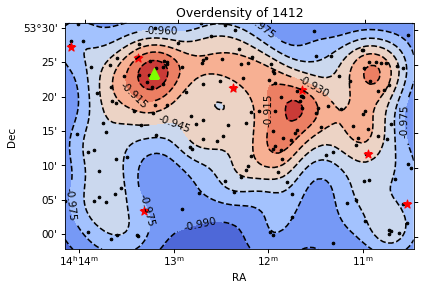

In [656]:
#### Overdensity map

gridwidth = 100# sampling step
xx, yy = np.meshgrid(np.arange(0, wcs1.array_shape[0], gridwidth), np.arange(0, wcs1.array_shape[1], gridwidth))
ra_xx, dec_yy = wcs1.all_pix2world(xx+gridwidth/2, yy+gridwidth/2, 1); ra_xx, dec_yy = 60*ra_xx, 60*dec_yy
f = [Gaussian2D(np.sqrt((ra_xx - emitter[0, i])**2 + (dec_yy - emitter[1, i])**2), Sigma) for i in range(len(emitter[0]))]
f = np.sum(f, axis=0)/v/15**3 -1
# f = np.sum(f, axis=0)/len(Bw_select['lyaLuminosity']) -1
center = (gridwidth*(np.where(f == np.max(f))[1][0] + 1/2), gridwidth*(np.where(f == np.max(f))[0][0] +1/2))

fig = plt.figure(figsize=(8, 8))
fig = plt.figure()
ax = fig.gca(projection=wcs1)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm', lw=1)
cset = ax.contour(xx, yy, f, colors='k', lw=1)
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.axis([xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]])
plt.scatter(Bw_select.NB_X, Bw_select.NB_Y, marker='.', color='black', s=25)
plt.scatter(blob.NB_X, blob.NB_Y, marker='*', color='r', s=75)
plt.scatter(center[0], center[1], marker='^', color='chartreuse', s=100)
plt.title('Overdensity of 1412')
plt.show()

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


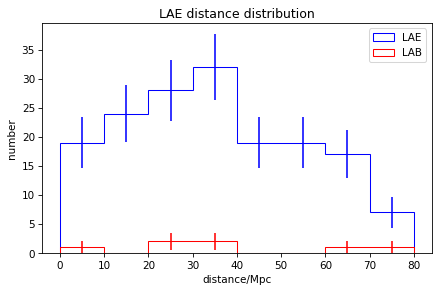

In [657]:
#### LAB density distribution from overdensest peak

Center = wcs1.all_pix2world(center[0], center[1],1)

Emitter = Bw_select.drop(blob.index)
Emitter['distance'] = np.sqrt((Emitter.ALPHA_J2000 - Center[0])**2 + (Emitter.DELTA_J2000-Center[1])**2)*(2*np.pi/360) * cosmo.comoving_distance(z)
blob['distance'] = np.sqrt((blob.ALPHA_J2000-Center[0])**2 + (blob.DELTA_J2000-Center[1])**2)*(2*np.pi/360) * cosmo.comoving_distance(z)

binwidth = 10
x = np.arange(binwidth/2, binwidth*(max(Emitter['distance'])//binwidth + 3/2), binwidth)
y1 = np.histogram(Emitter['distance'], bins=np.arange(0, binwidth*(max(Emitter['distance'])//binwidth + 2), binwidth))[0]
y2 = np.histogram(blob['distance'], bins=np.arange(0, binwidth*(max(Emitter['distance'])//binwidth + 2), binwidth))[0]

X1 = np.delete(np.vstack([x, y1]), np.where(y1==0) ,axis=1)
X2 = np.delete(np.vstack([x, y2]), np.where(y2==0) ,axis=1)
error1 = np.sqrt(X1[1])
error2 = np.sqrt(X2[1])

plt.hist(Emitter['distance'], histtype='step', bins=np.arange(0, binwidth*(max(Emitter['distance'])//binwidth + 2), binwidth), color='b')
plt.errorbar(X1[0], X1[1], fmt='None', yerr=error1, ecolor='b')
plt.hist(blob['distance'], histtype='step', bins=np.arange(0, binwidth*(max(Emitter['distance'])//binwidth + 2), binwidth), color='r')
plt.legend(['LAE', 'LAB'])
plt.errorbar(X2[0], X2[1], fmt='None', yerr=error2, ecolor='r')
plt.xlabel('distance/Mpc')
plt.ylabel('number')
plt.title('LAE distance distribution')
plt.tight_layout()
plt.show()

D:\software\Anaconda\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


<Figure size 600x600 with 0 Axes>

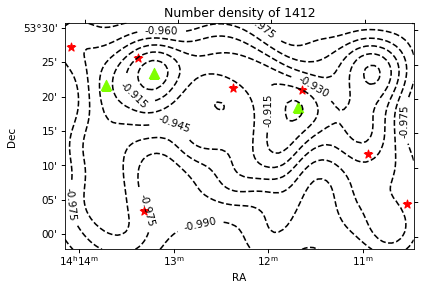

In [658]:
# select peak
peak1 = (gridwidth*(np.where(f[:,:10] == np.max(f[:,:10]))[1][0] + 1/2), gridwidth*(np.where(f[:,:10] == np.max(f[:,:10]))[0][0] +1/2))
peak2 = (gridwidth*(np.where(f[:, 50:80] == np.max(f[:, 50:80]))[1][0] + 1/2 + 50), gridwidth*(np.where(f[:, 50:80] == np.max(f[:, 50:80]))[0][0] +1/2))

fig = plt.figure(figsize=(8, 8))
fig = plt.figure()
ax = fig.gca(projection=wcs1)
cset = ax.contour(xx, yy, f, colors='k', lw=1)
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.axis([xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]])
plt.scatter(peak1[0], peak1[1], marker='^', color='chartreuse', s=100)
plt.scatter(peak2[0], peak2[1], marker='^', color='chartreuse', s=100)
plt.scatter(center[0], center[1], marker='^', color='chartreuse', s=100)
plt.scatter(blob.NB_X, blob.NB_Y, marker='*', color='r', s=75)
plt.title('Number density of 1412')
plt.show()

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


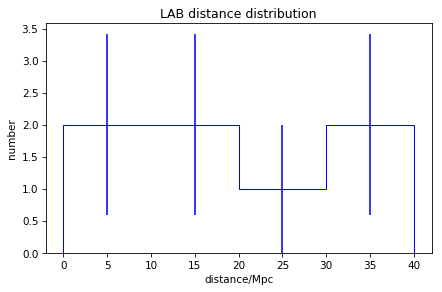

In [659]:
#### LAB density distribution from nearest peak

Peak = wcs1.all_pix2world([center[0], peak1[0], peak2[0]], [center[1], peak1[1], peak2[1]] ,1)

Dist = np.array([np.sqrt((blob.ALPHA_J2000-Peak[0][i])**2 + (blob.DELTA_J2000-Peak[1][i])**2)*(2*np.pi/360) * cosmo.comoving_distance(z).value for i in range(len(Peak[0]))])
blob['distance']=np.min(Dist, axis=0)

binwidth = 10
x = np.arange(binwidth/2, binwidth*(max(blob['distance'])//binwidth + 3/2), binwidth)
y = np.histogram(blob['distance'], bins=np.arange(0, binwidth*(max(blob['distance'])//binwidth + 2), binwidth))[0]

X = np.delete(np.vstack([x, y]), np.where(y==0) ,axis=1)
error = np.sqrt(X[1])

plt.hist(blob['distance'], histtype='step', bins=np.arange(0, binwidth*(max(blob['distance'])//binwidth + 2), binwidth), color='b')
plt.errorbar(X[0], X[1], fmt='None', yerr=error, ecolor='b')
plt.xlabel('distance/Mpc')
plt.ylabel('number')
plt.title('LAB distance distribution')
plt.tight_layout()
plt.show()